# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [9]:
#!unzip /content/sample_data/Train_rev1.zip

In [10]:
#!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
#!unzip Train_rev1.zip
#/content/sample_data/Train_rev1.csv
#, error_bad_lines=False, quoting=csv.QUOTE_NONE
data = pd.read_csv("/content/Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [11]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [12]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

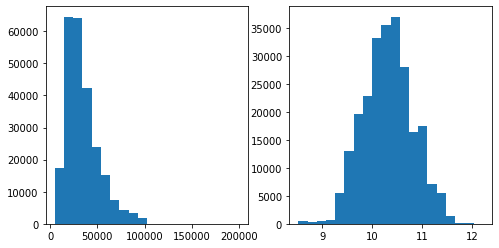

In [13]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [14]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
76022,69005242,Science Teacher,Science Maternity Cover Our client school is l...,"Saint Albans, Hertfordshire",St. Albans,part_time,NaN,County Teachers,Teaching Jobs,135 - 191/day,39120,cv-library.co.uk,10.574414
114670,69753059,CNC Centre Lathe Operator UK,CNC Machinist Our client who specialises in Ar...,"Dundee, UK",Dundee,NaN,NaN,NaN,"Energy, Oil & Gas Jobs",480 - 540 per week + ov...,24480,oilandgasjobsearch.com,10.105653
68437,68785527,Stock Controller Luxury French Brand Selfridges,Stock Controller Luxury French Contemporary b...,London South East,South East London,NaN,permanent,Elite Associates,Retail Jobs,17000 - 18000 per annum + BONUSES,17500,retailchoice.com,9.770013


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [15]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [16]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [17]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [18]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [19]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


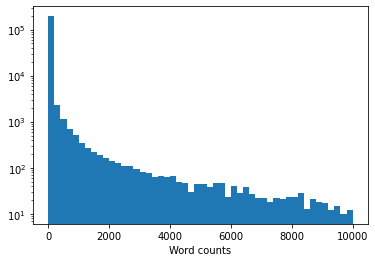

In [20]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [21]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [22]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [23]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [24]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [25]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [26]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [27]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [28]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [29]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [30]:
make_batch(data_train[:3], max_len=10)

{'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'FullDescription': tensor([[32937, 31100, 33664, 12587,   982, 17753, 11192,  1693,   943,  8110],
         [ 2572, 33996,   982, 13650,   158, 33554,   982,   437, 22021,    82],
         [33996, 33435, 30323, 33554,  3002, 20893, 11312,   158,  7151, 31100]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631]),
 'Title': tensor([[27645, 26986,  1587,   197, 11192,  1700],
         [27280, 13650, 30409,  2844,     1,     1],
         [ 4986,  9083, 18864,     1,     1,     1]])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [31]:
import torch
import torch.nn as nn
import torch.functional as F

In [32]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [33]:
model = SalaryPredictor()

In [34]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [35]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [40]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cpu')

In [37]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [38]:
def train_model(model_, criterion_, optimizer_, early_stop=False):
  mae = []
  mse = []
  losses = []
  MAX_ITER = 5

  for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    cur_iter = 0
    prev_loss = float("inf")
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        model_.train()
        pred = model_(batch)
        optimizer_.zero_grad()
        loss = criterion_(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer_.step()

        if i % 100 == 99:
            print('train_loss', loss.item())
            mse_, mae_ = print_metrics(model_, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
            mse.append(mse_)
            mae.append(mae_)
            losses.append(loss.item())

            cur_loss = loss.item()
            if cur_loss >= prev_loss and early_stop: # task 1.3 early stop train
              cur_iter += 1
              if cur_iter > MAX_ITER:
                print(f"Early stopping. Loss not decrease for {MAX_ITER} iterations")
                break
            else:
              cur_iter = 0 
            prev_loss = cur_loss

  # mae, mse, losses plots
  print(f"Final results: mse: {mse[-1]}, mae: {mae[-1]}")
  plt.ion()
  plt.figure(figsize=(10, 10))
  plt.plot(mae, "g^")
  plt.plot(mse, "bs")
  plt.plot(losses, "r--")
  plt.show()

In [41]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Task 1

In [42]:
class NetworkParams:
    #max_grad_norm=1000
    hidden_size=64
    dropout=0.3
    lr=5e-2
    #weight_decay=1e-6
    #batch_size=32
    #epochs=20
    #n_features=len(USECOLS)
    #n_target_cols=len(TARGET_COLS)

net_params = NetworkParams()

In [ ]:
class FirstModel(nn.Module):
    def __init__(self, net_params, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, net_params.hidden_size)
        self.title_encoder_left = nn.Sequential(
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2),
            nn.BatchNorm1d(net_params.hidden_size), # task 1.1 batchNorm
            nn.Dropout(p=net_params.dropout),
            nn.ELU(),
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2), # task 1.2 several Conv1d
            nn.BatchNorm1d(net_params.hidden_size), # task 1.1 batchNorm
            nn.Dropout(p=net_params.dropout),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.title_encoder_right = nn.Sequential(
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2),
            nn.BatchNorm1d(net_params.hidden_size), # task 1.1 batchNorm
            nn.Dropout(p=net_params.dropout),
            nn.ELU(),
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2), # task 1.2 several Conv1d
            nn.BatchNorm1d(net_params.hidden_size), # task 1.1 batchNorm
            nn.Dropout(p=net_params.dropout),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder_left = nn.Sequential(
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2),
            nn.BatchNorm1d(net_params.hidden_size), # task 1.1 batchNorm
            nn.Dropout(p=net_params.dropout),
            nn.ELU(),
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2), # task 1.2 several Conv1d
            nn.BatchNorm1d(net_params.hidden_size), # task 1.1 batchNorm
            nn.Dropout(p=net_params.dropout),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder_right = nn.Sequential(
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2),
            nn.BatchNorm1d(net_params.hidden_size), # task 1.1 batchNorm
            nn.Dropout(p=net_params.dropout),
            nn.ELU(),
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2), # task 1.2 several Conv1d
            nn.BatchNorm1d(net_params.hidden_size), # task 1.1 batchNorm
            nn.Dropout(p=net_params.dropout),
            nn.ELU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, net_params.hidden_size * 2),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size * 2, net_params.hidden_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(net_params.hidden_size * 4),
            nn.ReLU(),
            nn.LazyLinear(net_params.hidden_size * 2),
            nn.LeakyReLU(),
            nn.LazyLinear(1),
            # nn.Linear(net_params.hidden_size * 4, net_params.hidden_size),
            # nn.ReLU(),
            # nn.Linear(net_params.hidden_size, 1)
        )

        
    def forward(self, batch):

        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features_left = self.title_encoder_left(title_embeddings).squeeze()
        title_features_right = self.title_encoder_right(title_embeddings).squeeze()
        title_features = torch.cat([title_features_left, title_features_right], dim=1)
        
        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features_left = self.description_encoder_left(description_embeddings).squeeze()
        description_features_right = self.description_encoder_right(description_embeddings).squeeze()
        description_features = torch.cat([description_features_left, description_features_right], dim=1)
        
        features = torch.cat([title_features, description_features], dim=1)
        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat([features, categorical_features], dim=1)
        
        result = self.final_predictor(features).squeeze()

        return result

In [ ]:
model_first_task = FirstModel(net_params=net_params).to(DEVICE)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_first_task.parameters(), lr=net_params.lr)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 3.990779161453247
val results:
Mean square error: 0.18988
Mean absolute error: 0.16738
train_loss 0.9871675968170166
val results:
Mean square error: 0.33007
Mean absolute error: 0.24862
train_loss 0.244981586933136
val results:
Mean square error: 0.06591
Mean absolute error: 0.10199
train_loss 0.2832990884780884
val results:
Mean square error: 0.06569
Mean absolute error: 0.10192
train_loss 0.3250148892402649
val results:
Mean square error: 0.06709
Mean absolute error: 0.10401
train_loss 0.2372840940952301
val results:
Mean square error: 0.06220
Mean absolute error: 0.09993
train_loss 0.25096797943115234
val results:
Mean square error: 0.06187
Mean absolute error: 0.09982
train_loss 0.2527717351913452
val results:
Mean square error: 0.06268
Mean absolute error: 0.10053
train_loss 0.19295454025268555
val results:
Mean square error: 0.06190
Mean absolute error: 0.09969
train_loss 0.19221769273281097
val results:
Mean square error: 0.06183
Mean absolute error: 0.09970
train_los

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.20938105881214142
val results:
Mean square error: 0.06168
Mean absolute error: 0.09961
train_loss 0.24538904428482056
val results:
Mean square error: 0.06220
Mean absolute error: 0.09994
train_loss 0.18976058065891266
val results:
Mean square error: 0.06271
Mean absolute error: 0.10053
train_loss 0.2698037624359131
val results:
Mean square error: 0.06208
Mean absolute error: 0.09985
train_loss 0.2289351522922516
val results:
Mean square error: 0.06180
Mean absolute error: 0.09963
train_loss 0.25240060687065125
val results:
Mean square error: 0.06194
Mean absolute error: 0.09974
train_loss 0.2434302568435669
val results:
Mean square error: 0.06181
Mean absolute error: 0.09976
train_loss 0.20730814337730408
val results:
Mean square error: 0.06175
Mean absolute error: 0.09962
train_loss 0.17122283577919006
val results:
Mean square error: 0.06173
Mean absolute error: 0.09954
train_loss 0.27482515573501587
val results:
Mean square error: 0.06138
Mean absolute error: 0.09934
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.25225627422332764
val results:
Mean square error: 0.06266
Mean absolute error: 0.10057
train_loss 0.22973565757274628
val results:
Mean square error: 0.06209
Mean absolute error: 0.09994
train_loss 0.2148394137620926
val results:
Mean square error: 0.06352
Mean absolute error: 0.10139
train_loss 0.23246482014656067
val results:
Mean square error: 0.06166
Mean absolute error: 0.09966
train_loss 0.21767601370811462
val results:
Mean square error: 0.06195
Mean absolute error: 0.09977
train_loss 0.19341322779655457
val results:
Mean square error: 0.06358
Mean absolute error: 0.10087
train_loss 0.2189578413963318
val results:
Mean square error: 0.06171
Mean absolute error: 0.09966
train_loss 0.22290514409542084
val results:
Mean square error: 0.06177
Mean absolute error: 0.09964
train_loss 0.20492219924926758
val results:
Mean square error: 0.06376
Mean absolute error: 0.10103
train_loss 0.2550395131111145
val results:
Mean square error: 0.06172
Mean absolute error: 0.09959
tra

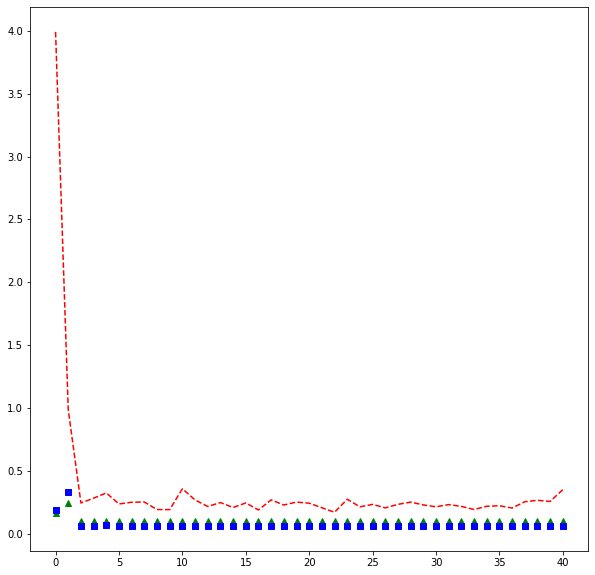

In [ ]:
train_model(model_first_task, criterion, optimizer, early_stop=True)

При количестве слоев 8 / 16 / 128 / 512 mse и mae были довольно большими, удалось уменьшить их с кол-во слоев, равным 64. Так же пробовал использовать одинарный LazyLinear для categorical_encoder, но это так же приводило к болишьм значениям ошибок. Здесь используется применение параллельных слоев свертки к эмбедингам, а также увеличенно их количество последовательно.

# Task 2

Описание пулинг слоя: Несколько раз выбираются последовательно несколько элементов, расположенных рядом, внезависимости от размерности. Из этих элементов выбираются меньшее количество по критерию, или максимальные, или средние, или другие в зависимости от типа pooling слоя.

In [ ]:
class SalaryPredictorMaxPooling(nn.Module):
    def __init__(self, net_params, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, net_params.hidden_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2),
            nn.Dropout(p=net_params.dropout),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=net_params.hidden_size),
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2),
            nn.Dropout(p=net_params.dropout),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=net_params.hidden_size),
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, net_params.hidden_size * 2),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size * 2, net_params.hidden_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(net_params.hidden_size),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        
        title_features = torch.flatten(title_features, start_dim=1)
        description_features = torch.flatten(description_features, start_dim=1)
        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
class SalaryPredictorAvgPooling(nn.Module):
    def __init__(self, net_params, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, net_params.hidden_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2),
            nn.Dropout(p=net_params.dropout),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=net_params.hidden_size),
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(net_params.hidden_size, net_params.hidden_size, kernel_size=2),
            nn.Dropout(p=net_params.dropout),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=net_params.hidden_size),
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, net_params.hidden_size * 2),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size * 2, net_params.hidden_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.LazyLinear(net_params.hidden_size),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        
        title_features = torch.flatten(title_features, start_dim=1)
        description_features = torch.flatten(description_features, start_dim=1)
        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 111.33438110351562
val results:
Mean square error: 27.63436
Mean absolute error: 2.62552
train_loss 104.22245788574219
val results:
Mean square error: 26.21633
Mean absolute error: 2.55712
train_loss 97.02833557128906
val results:
Mean square error: 24.44699
Mean absolute error: 2.46911
train_loss 91.6278305053711
val results:
Mean square error: 22.45857
Mean absolute error: 2.36631
train_loss 82.00665283203125
val results:
Mean square error: 20.34724
Mean absolute error: 2.25202
train_loss 72.10546112060547
val results:
Mean square error: 18.18941
Mean absolute error: 2.12888
train_loss 64.5392837524414
val results:
Mean square error: 16.05010
Mean absolute error: 1.99933
train_loss 56.73938751220703
val results:
Mean square error: 13.98006
Mean absolute error: 1.86542
train_loss 46.63200759887695
val results:
Mean square error: 12.01953
Mean absolute error: 1.72907
train_loss 39.913238525390625
val results:
Mean square error: 10.19914
Mean absolute error: 1.59203
train_los

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 6.56123161315918
val results:
Mean square error: 1.56095
Mean absolute error: 0.61239
train_loss 4.743846893310547
val results:
Mean square error: 1.16274
Mean absolute error: 0.52485
train_loss 3.3192615509033203
val results:
Mean square error: 0.85540
Mean absolute error: 0.44569
train_loss 2.4063167572021484
val results:
Mean square error: 0.62269
Mean absolute error: 0.37506
train_loss 1.9642562866210938
val results:
Mean square error: 0.45004
Mean absolute error: 0.31269
train_loss 1.4214081764221191
val results:
Mean square error: 0.32479
Mean absolute error: 0.25839
train_loss 0.8796083927154541
val results:
Mean square error: 0.23585
Mean absolute error: 0.21252
train_loss 0.7144862413406372
val results:
Mean square error: 0.17346
Mean absolute error: 0.17613
train_loss 0.5200729370117188
val results:
Mean square error: 0.13163
Mean absolute error: 0.14951
train_loss 0.38959676027297974
val results:
Mean square error: 0.10447
Mean absolute error: 0.13104
train_loss 0

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.23061132431030273
val results:
Mean square error: 0.06107
Mean absolute error: 0.09911
train_loss 0.17727705836296082
val results:
Mean square error: 0.06095
Mean absolute error: 0.09902
train_loss 0.23569759726524353
val results:
Mean square error: 0.06090
Mean absolute error: 0.09897
train_loss 0.27497774362564087
val results:
Mean square error: 0.06087
Mean absolute error: 0.09892
train_loss 0.24740198254585266
val results:
Mean square error: 0.06086
Mean absolute error: 0.09893
train_loss 0.28746557235717773
val results:
Mean square error: 0.06086
Mean absolute error: 0.09897
train_loss 0.23853297531604767
val results:
Mean square error: 0.06086
Mean absolute error: 0.09898
train_loss 0.2135424017906189
val results:
Mean square error: 0.06086
Mean absolute error: 0.09898
train_loss 0.2705591917037964
val results:
Mean square error: 0.06086
Mean absolute error: 0.09900
train_loss 0.23606255650520325
val results:
Mean square error: 0.06087
Mean absolute error: 0.09901
tr

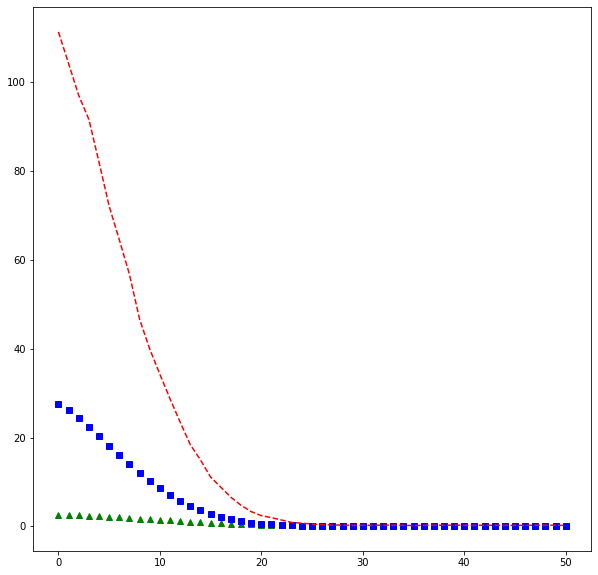

In [ ]:
maxpooling_model = SalaryPredictorMaxPooling(net_params=net_params).to(DEVICE)

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(maxpooling_model.parameters(), net_params.lr)

train_model(maxpooling_model, criterion, optimizer, early_stop=True)

epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 105.59068298339844
val results:
Mean square error: 26.50945
Mean absolute error: 2.57141
train_loss 96.87998962402344
val results:
Mean square error: 24.21112
Mean absolute error: 2.45715
train_loss 86.38320922851562
val results:
Mean square error: 21.46891
Mean absolute error: 2.31344
train_loss 75.56023406982422
val results:
Mean square error: 18.55740
Mean absolute error: 2.15038
train_loss 63.463226318359375
val results:
Mean square error: 15.66468
Mean absolute error: 1.97508
train_loss 51.42973327636719
val results:
Mean square error: 12.92900
Mean absolute error: 1.79361
train_loss 41.94384765625
val results:
Mean square error: 10.44085
Mean absolute error: 1.61090
train_loss 32.23150634765625
val results:
Mean square error: 8.24666
Mean absolute error: 1.43054
train_loss 25.00341796875
val results:
Mean square error: 6.37408
Mean absolute error: 1.25631
train_loss 19.60692024230957
val results:
Mean square error: 4.81797
Mean absolute error: 1.09054
train_loss 14.166

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.8926830887794495
val results:
Mean square error: 0.24082
Mean absolute error: 0.21526
train_loss 0.6803288459777832
val results:
Mean square error: 0.16653
Mean absolute error: 0.17187
train_loss 0.5554124116897583
val results:
Mean square error: 0.12107
Mean absolute error: 0.14246
train_loss 0.3391086459159851
val results:
Mean square error: 0.09387
Mean absolute error: 0.12352
train_loss 0.2580368220806122
val results:
Mean square error: 0.07803
Mean absolute error: 0.11186
train_loss 0.27498576045036316
val results:
Mean square error: 0.06957
Mean absolute error: 0.10537
train_loss 0.23986566066741943
val results:
Mean square error: 0.06511
Mean absolute error: 0.10207
train_loss 0.2689770460128784
val results:
Mean square error: 0.06284
Mean absolute error: 0.10030
train_loss 0.23914581537246704
val results:
Mean square error: 0.06174
Mean absolute error: 0.09957
train_loss 0.21425873041152954
val results:
Mean square error: 0.06124
Mean absolute error: 0.09923
train_

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.2603026032447815
val results:
Mean square error: 0.06086
Mean absolute error: 0.09897
train_loss 0.2653387188911438
val results:
Mean square error: 0.06086
Mean absolute error: 0.09898
train_loss 0.2794451117515564
val results:
Mean square error: 0.06086
Mean absolute error: 0.09897
train_loss 0.29732224345207214
val results:
Mean square error: 0.06086
Mean absolute error: 0.09899
train_loss 0.22176992893218994
val results:
Mean square error: 0.06086
Mean absolute error: 0.09900
train_loss 0.1960228681564331
val results:
Mean square error: 0.06086
Mean absolute error: 0.09898
train_loss 0.25319451093673706
val results:
Mean square error: 0.06086
Mean absolute error: 0.09896
train_loss 0.26823723316192627
val results:
Mean square error: 0.06086
Mean absolute error: 0.09894
train_loss 0.25420665740966797
val results:
Mean square error: 0.06087
Mean absolute error: 0.09901
train_loss 0.278439998626709
val results:
Mean square error: 0.06088
Mean absolute error: 0.09905
train_

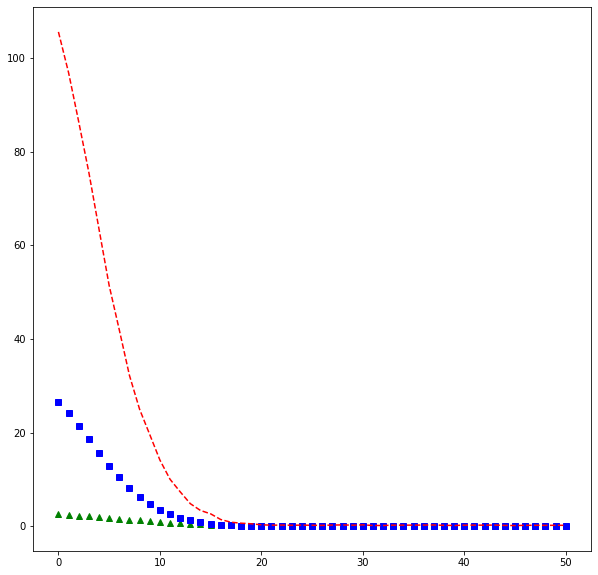

In [ ]:
avgpooling_model = SalaryPredictorAvgPooling(net_params=net_params).to(DEVICE)

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(avgpooling_model.parameters(), net_params.lr)

train_model(avgpooling_model, criterion, optimizer, early_stop=True)

По сравнению с моделью из первого задания значение mse и mae особо не изменились, а вот train_loss получилось сделать более стабильным, но само значение сильно лучше не стало. Так же можно заметить, что на первых итерациях значения здесь сильно лучше, но к концу тренировки они стабильно становятся хорошими.

# Task 3

In [ ]:
import gensim.downloader as gs
language_model = gs.load("glove-wiki-gigaword-50") # task 3.1

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
weights = torch.FloatTensor(language_model.vectors)
emb_size = 50

In [ ]:
class SalaryPredictorEmbLearning(nn.Module): # task 3.3 learning embedding
    def __init__(self, net_params, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights) # task 3.2
        self.embedder.requires_grad_ = True
        self.title_encoder = nn.Sequential(
            nn.Conv1d(emb_size, net_params.hidden_size, kernel_size=2),
            nn.Dropout(p=net_params.dropout),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(emb_size, net_params.hidden_size, kernel_size=2),
            nn.Dropout(p=net_params.dropout),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, net_params.hidden_size * 2),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size * 2, net_params.hidden_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(net_params.hidden_size * 4, net_params.hidden_size),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1) # task 3.3 same embeddings for title and description
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1) # task 3.3 same embeddings for title and description
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()
    
class SalaryPredictorEmbFreeze(nn.Module): # task 3.3 freezed embedding
    def __init__(self, net_params, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.embedder = nn.Embedding.from_pretrained(weights) # task 3.2
        self.embedder.requires_grad_ = False
        self.title_encoder = nn.Sequential(
            nn.Conv1d(emb_size, net_params.hidden_size, kernel_size=2),
            nn.Dropout(p=net_params.dropout),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(emb_size, net_params.hidden_size, kernel_size=2),
            nn.Dropout(p=net_params.dropout),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, net_params.hidden_size * 2),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size * 2, net_params.hidden_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(net_params.hidden_size * 4, net_params.hidden_size),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1) # task 3.3 same embeddings for title and description
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1) # task 3.3 same embeddings for title and description
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.9368659257888794
val results:
Mean square error: 1.90593
Mean absolute error: 0.66863
train_loss 0.49050939083099365
val results:
Mean square error: 1.11811
Mean absolute error: 0.51241
train_loss 0.3231937885284424
val results:
Mean square error: 0.90289
Mean absolute error: 0.46077
train_loss 0.3033086359500885
val results:
Mean square error: 0.58461
Mean absolute error: 0.36722
train_loss 0.19678032398223877
val results:
Mean square error: 0.74372
Mean absolute error: 0.41897
train_loss 0.19930684566497803
val results:
Mean square error: 0.93161
Mean absolute error: 0.47259
train_loss 0.27422332763671875
val results:
Mean square error: 0.55370
Mean absolute error: 0.35935
train_loss 0.17145761847496033
val results:
Mean square error: 0.52207
Mean absolute error: 0.34881
train_loss 0.19412632286548615
val results:
Mean square error: 0.60796
Mean absolute error: 0.37838
train_loss 0.13245874643325806
val results:
Mean square error: 0.49024
Mean absolute error: 0.33790
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1368427574634552
val results:
Mean square error: 0.40858
Mean absolute error: 0.30774
train_loss 0.18175116181373596
val results:
Mean square error: 0.64975
Mean absolute error: 0.39379
train_loss 0.17155267298221588
val results:
Mean square error: 0.86966
Mean absolute error: 0.45774
train_loss 0.11376617848873138
val results:
Mean square error: 0.58119
Mean absolute error: 0.37153
train_loss 0.15709161758422852
val results:
Mean square error: 0.81584
Mean absolute error: 0.44367
train_loss 0.14027582108974457
val results:
Mean square error: 0.48375
Mean absolute error: 0.33775
train_loss 0.12799397110939026
val results:
Mean square error: 0.56763
Mean absolute error: 0.36741
train_loss 0.15197765827178955
val results:
Mean square error: 0.76372
Mean absolute error: 0.42834
train_loss 0.19218945503234863
val results:
Mean square error: 0.47969
Mean absolute error: 0.33642
train_loss 0.11427441239356995
val results:
Mean square error: 0.70101
Mean absolute error: 0.40997
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.18924416601657867
val results:
Mean square error: 0.06086
Mean absolute error: 0.09899
train_loss 0.21783803403377533
val results:
Mean square error: 0.06086
Mean absolute error: 0.09894
train_loss 0.2918487787246704
val results:
Mean square error: 0.06087
Mean absolute error: 0.09904
train_loss 0.22837695479393005
val results:
Mean square error: 0.06089
Mean absolute error: 0.09907
train_loss 0.2836783528327942
val results:
Mean square error: 0.06088
Mean absolute error: 0.09906
train_loss 0.23733007907867432
val results:
Mean square error: 0.06087
Mean absolute error: 0.09903
train_loss 0.24879245460033417
val results:
Mean square error: 0.06089
Mean absolute error: 0.09895
train_loss 0.2656531035900116
val results:
Mean square error: 0.06086
Mean absolute error: 0.09900
train_loss 0.26277971267700195
val results:
Mean square error: 0.06087
Mean absolute error: 0.09901
train_loss 0.17336173355579376
val results:
Mean square error: 0.06090
Mean absolute error: 0.09910
tra

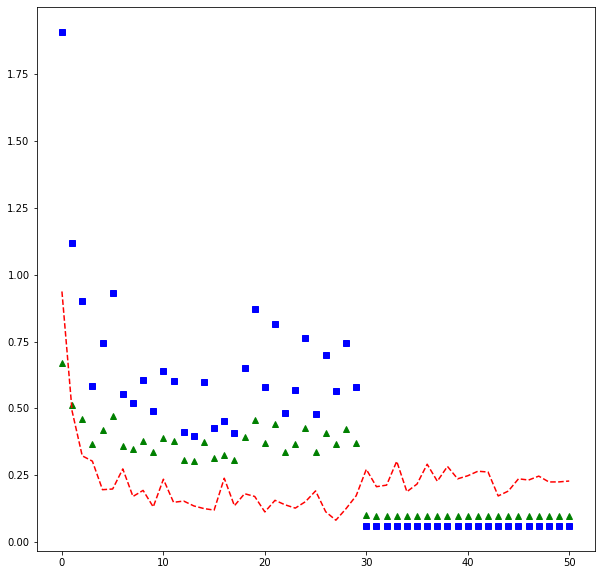

In [ ]:
emb_freeze_model = SalaryPredictorEmbFreeze(net_params=net_params).to(DEVICE)

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(emb_freeze_model.parameters(), lr=net_params.lr)

train_model(emb_freeze_model, criterion, optimizer, early_stop=True)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.6278954148292542
val results:
Mean square error: 1.96501
Mean absolute error: 0.68404
train_loss 0.625408411026001
val results:
Mean square error: 1.80121
Mean absolute error: 0.65903
train_loss 0.35624009370803833
val results:
Mean square error: 1.83062
Mean absolute error: 0.66693
train_loss 0.2047385573387146
val results:
Mean square error: 1.70687
Mean absolute error: 0.64463
train_loss 0.21557509899139404
val results:
Mean square error: 1.80764
Mean absolute error: 0.66437
train_loss 0.18552245199680328
val results:
Mean square error: 1.69961
Mean absolute error: 0.64432
train_loss 0.14430251717567444
val results:
Mean square error: 1.34235
Mean absolute error: 0.57132
train_loss 0.29274728894233704
val results:
Mean square error: 1.23983
Mean absolute error: 0.54881
train_loss 0.31966108083724976
val results:
Mean square error: 1.49783
Mean absolute error: 0.60439
train_loss 0.14027039706707
val results:
Mean square error: 1.20463
Mean absolute error: 0.54104
train_l

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.12648026645183563
val results:
Mean square error: 0.82692
Mean absolute error: 0.44593
train_loss 0.15201297402381897
val results:
Mean square error: 0.93576
Mean absolute error: 0.47608
train_loss 0.133207768201828
val results:
Mean square error: 0.69050
Mean absolute error: 0.40712
train_loss 0.14511191844940186
val results:
Mean square error: 0.81906
Mean absolute error: 0.44451
train_loss 0.11594729870557785
val results:
Mean square error: 0.68237
Mean absolute error: 0.40444
train_loss 0.13293686509132385
val results:
Mean square error: 0.56000
Mean absolute error: 0.36464
train_loss 0.1343434602022171
val results:
Mean square error: 0.44746
Mean absolute error: 0.32418
train_loss 0.11718735098838806
val results:
Mean square error: 0.51490
Mean absolute error: 0.34914
train_loss 0.12196577340364456
val results:
Mean square error: 0.49933
Mean absolute error: 0.34359
train_loss 0.1687120497226715
val results:
Mean square error: 0.34238
Mean absolute error: 0.28125
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.0984320193529129
val results:
Mean square error: 0.25255
Mean absolute error: 0.23825
train_loss 0.13147549331188202
val results:
Mean square error: 0.16550
Mean absolute error: 0.18794
train_loss 0.1389816403388977
val results:
Mean square error: 0.15430
Mean absolute error: 0.18058
train_loss 0.12792614102363586
val results:
Mean square error: 0.15097
Mean absolute error: 0.17861
train_loss 0.1748315393924713
val results:
Mean square error: 0.15621
Mean absolute error: 0.18180
train_loss 0.12066078186035156
val results:
Mean square error: 0.09999
Mean absolute error: 0.13933
train_loss 0.18651562929153442
val results:
Mean square error: 0.14059
Mean absolute error: 0.17082
train_loss 0.13329574465751648
val results:
Mean square error: 0.14464
Mean absolute error: 0.17456
train_loss 0.08536870777606964
val results:
Mean square error: 0.07872
Mean absolute error: 0.12084
train_loss 0.11693014204502106
val results:
Mean square error: 0.11709
Mean absolute error: 0.15328
tra

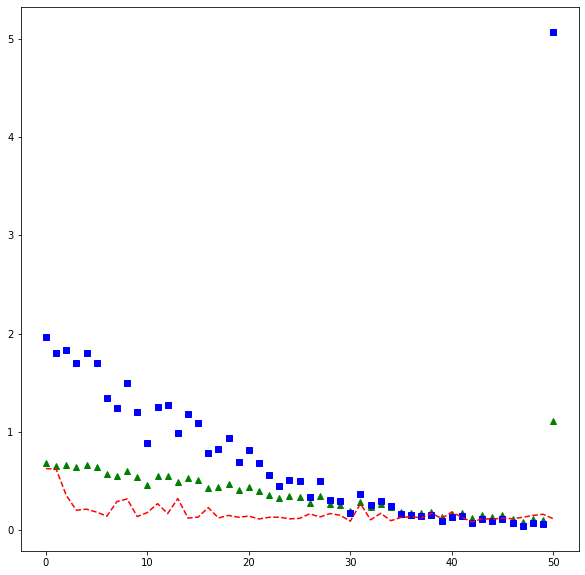

In [ ]:
emb_learning_model = SalaryPredictorEmbLearning(net_params=net_params).to(DEVICE)

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(emb_learning_model.parameters(), lr=net_params.lr)

train_model(emb_learning_model, criterion, optimizer, early_stop=True)

Хотя финальная ошибка оказалась такой большой, в среднем она была на уровне предудщих моделей, а train_loss имел нисходящий тренд. Т.е. есть тенденция к улучшению качества. Предпологаю, что, из-за не очень большой вариативности слов, но на достаточно большом кол-ве данных, эмбединги, которые мы получили на базовой модели вполне нормально позволяют предсказывать зарплату.

# Task 4

In [ ]:
class SalaryPredictorLSTMLayers(nn.Module):
    def __init__(self, net_params, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, net_params.hidden_size)
        self.title_encoder = nn.Sequential(
            nn.LSTM(net_params.hidden_size, net_params.hidden_size, bidirectional=True, num_layers=2),
        )
        self.description_encoder = nn.Sequential(
            nn.LSTM(net_params.hidden_size, net_params.hidden_size, bidirectional=True, num_layers=2),
        )
        
        self.prepooling = nn.Sequential(nn.AdaptiveMaxPool1d(output_size=net_params.hidden_size))
        
        self.pooling = nn.Sequential(
            nn.Dropout(p=net_params.dropout),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1),
        )
        
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, net_params.hidden_size * 2),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size * 2, net_params.hidden_size * 2),
            nn.ReLU()
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(net_params.hidden_size * 4, net_params.hidden_size),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_embeddings = self.prepooling(title_embeddings)
        title_features = self.title_encoder(title_embeddings)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_embeddings = self.prepooling(description_embeddings)
        description_features = self.description_encoder(description_embeddings)

        categorical_features = self.categorical_encoder(batch['Categorical'])
        
        title_features = self.pooling(title_features[0]).squeeze()
        description_features = self.pooling(description_features[0]).squeeze()

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()
    
class SalaryPredictorGRULayers(nn.Module):
    def __init__(self, net_params, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, net_params.hidden_size)
        self.title_encoder = nn.Sequential(
            nn.GRU(net_params.hidden_size, net_params.hidden_size, bidirectional=True, num_layers=2),
        )
        self.description_encoder = nn.Sequential(
            nn.GRU(net_params.hidden_size, net_params.hidden_size, bidirectional=True, num_layers=2),
        )
        
        self.prepooling = nn.Sequential(nn.AdaptiveMaxPool1d(output_size=net_params.hidden_size))
        
        self.pooling = nn.Sequential(
            nn.Dropout(p=net_params.dropout),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1),
        )
        
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, net_params.hidden_size * 2),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size * 2, net_params.hidden_size * 2),
            nn.ReLU()
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(net_params.hidden_size * 4, net_params.hidden_size),
            nn.ReLU(),
            nn.Linear(net_params.hidden_size, 1)
        )
        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_embeddings = self.prepooling(title_embeddings)
        title_features = self.title_encoder(title_embeddings)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_embeddings = self.prepooling(description_embeddings)
        description_features = self.description_encoder(description_embeddings)

        categorical_features = self.categorical_encoder(batch['Categorical'])
        
        title_features = self.pooling(title_features[0]).squeeze()
        description_features = self.pooling(description_features[0]).squeeze()

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.23539087176322937
val results:
Mean square error: 2.15776
Mean absolute error: 0.72403
train_loss 0.22035175561904907
val results:
Mean square error: 2.30090
Mean absolute error: 0.74844
train_loss 0.3132174611091614
val results:
Mean square error: 2.26445
Mean absolute error: 0.74232
train_loss 0.24920408427715302
val results:
Mean square error: 2.12844
Mean absolute error: 0.71963
train_loss 0.19116808474063873
val results:
Mean square error: 2.08487
Mean absolute error: 0.71236
train_loss 0.24861079454421997
val results:
Mean square error: 2.27245
Mean absolute error: 0.74544
train_loss 0.21919487416744232
val results:
Mean square error: 2.19280
Mean absolute error: 0.73190
train_loss 0.18865102529525757
val results:
Mean square error: 2.08082
Mean absolute error: 0.71310
train_loss 0.1810738444328308
val results:
Mean square error: 2.44783
Mean absolute error: 0.77523
train_loss 0.18426819145679474
val results:
Mean square error: 2.31109
Mean absolute error: 0.75319
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.16935357451438904
val results:
Mean square error: 1.89349
Mean absolute error: 0.68087
train_loss 0.12868335843086243
val results:
Mean square error: 2.17530
Mean absolute error: 0.73081
train_loss 0.15130487084388733
val results:
Mean square error: 2.05898
Mean absolute error: 0.71063
train_loss 0.15226656198501587
val results:
Mean square error: 2.40959
Mean absolute error: 0.76985
train_loss 52.756202697753906
val results:
Mean square error: 0.10950
Mean absolute error: 0.13447
train_loss 0.22781994938850403
val results:
Mean square error: 1.20401
Mean absolute error: 0.53461
train_loss 0.24311426281929016
val results:
Mean square error: 1.12057
Mean absolute error: 0.51496
train_loss 0.23280251026153564
val results:
Mean square error: 1.17130
Mean absolute error: 0.52780
train_loss 0.16773450374603271
val results:
Mean square error: 1.07012
Mean absolute error: 0.50423
train_loss 0.2577933669090271
val results:
Mean square error: 1.12665
Mean absolute error: 0.51956
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.13666978478431702
val results:
Mean square error: 1.29568
Mean absolute error: 0.56067
train_loss 0.1420259028673172
val results:
Mean square error: 1.25726
Mean absolute error: 0.55204
train_loss 0.15015754103660583
val results:
Mean square error: 1.09647
Mean absolute error: 0.51440
train_loss 0.17982569336891174
val results:
Mean square error: 1.18818
Mean absolute error: 0.53616
train_loss 0.11034008115530014
val results:
Mean square error: 1.13423
Mean absolute error: 0.52349
train_loss 0.18755708634853363
val results:
Mean square error: 1.22269
Mean absolute error: 0.54419
train_loss 0.1649615466594696
val results:
Mean square error: 1.35240
Mean absolute error: 0.57324
train_loss 0.16572833061218262
val results:
Mean square error: 1.31560
Mean absolute error: 0.56518
train_loss 0.17751148343086243
val results:
Mean square error: 1.16158
Mean absolute error: 0.53003
train_loss 0.13504454493522644
val results:
Mean square error: 1.12479
Mean absolute error: 0.52129
tr

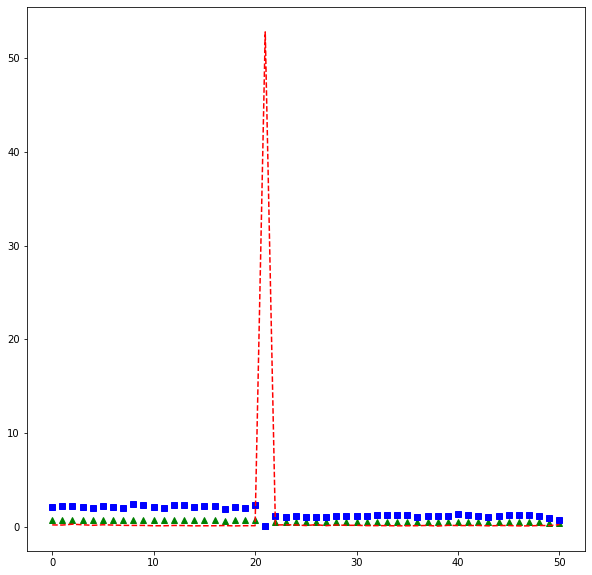

In [ ]:
lstm_model = SalaryPredictorLSTMLayers(net_params=net_params).to(DEVICE)

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=net_params.lr)

train_model(lstm_model, criterion, optimizer, early_stop=True)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.24769935011863708
val results:
Mean square error: 2.16616
Mean absolute error: 0.72548
train_loss 0.23275312781333923
val results:
Mean square error: 2.26358
Mean absolute error: 0.74208
train_loss 0.22913257777690887
val results:
Mean square error: 2.11111
Mean absolute error: 0.71593
train_loss 0.2243797332048416
val results:
Mean square error: 2.21668
Mean absolute error: 0.73414
train_loss 0.49799108505249023
val results:
Mean square error: 2.35028
Mean absolute error: 0.75706
train_loss 0.1473681628704071
val results:
Mean square error: 2.00158
Mean absolute error: 0.69932
train_loss 0.16956539452075958
val results:
Mean square error: 2.20484
Mean absolute error: 0.73531
train_loss 0.1618400514125824
val results:
Mean square error: 2.18904
Mean absolute error: 0.73302
train_loss 0.18676204979419708
val results:
Mean square error: 2.04461
Mean absolute error: 0.70816
train_loss 0.12310381233692169
val results:
Mean square error: 2.08520
Mean absolute error: 0.71529
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.20709827542304993
val results:
Mean square error: 2.05386
Mean absolute error: 0.71010
train_loss 0.15017089247703552
val results:
Mean square error: 2.19994
Mean absolute error: 0.73536
train_loss 0.1522357165813446
val results:
Mean square error: 1.98365
Mean absolute error: 0.69765
train_loss 0.13582192361354828
val results:
Mean square error: 1.89759
Mean absolute error: 0.68212
train_loss 0.2644444704055786
val results:
Mean square error: 2.21832
Mean absolute error: 0.73851
train_loss 0.1412225067615509
val results:
Mean square error: 2.03450
Mean absolute error: 0.70677
train_loss 0.15531767904758453
val results:
Mean square error: 2.09325
Mean absolute error: 0.71703
train_loss 0.13784649968147278
val results:
Mean square error: 2.00445
Mean absolute error: 0.70144
train_loss 0.13631021976470947
val results:
Mean square error: 2.02105
Mean absolute error: 0.70440
train_loss 0.15491102635860443
val results:
Mean square error: 2.16841
Mean absolute error: 0.73008
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.145382821559906
val results:
Mean square error: 2.15058
Mean absolute error: 0.72699
train_loss 0.11614146083593369
val results:
Mean square error: 1.96403
Mean absolute error: 0.69420
train_loss 0.10106830298900604
val results:
Mean square error: 2.07790
Mean absolute error: 0.71441
train_loss 0.16384950280189514
val results:
Mean square error: 1.63978
Mean absolute error: 0.63312
train_loss 0.33005163073539734
val results:
Mean square error: 1.91506
Mean absolute error: 0.68531
train_loss 0.16921311616897583
val results:
Mean square error: 1.65187
Mean absolute error: 0.63548
train_loss 0.12348973751068115
val results:
Mean square error: 1.74099
Mean absolute error: 0.65280
train_loss 0.1446152776479721
val results:
Mean square error: 1.77665
Mean absolute error: 0.65960
train_loss 0.1397380828857422
val results:
Mean square error: 1.78466
Mean absolute error: 0.66114
train_loss 0.1499910056591034
val results:
Mean square error: 1.87182
Mean absolute error: 0.67742
train

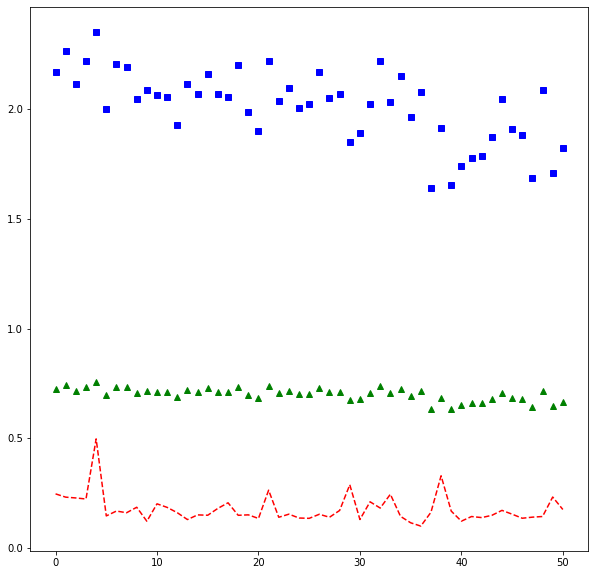

In [ ]:
gru_model = SalaryPredictorGRULayers(net_params=net_params).to(DEVICE)

criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(gru_model.parameters(), lr=net_params.lr)

train_model(gru_model, criterion, optimizer, early_stop=True)

Результаты GRU и LSTM оказались довольно похожими, величина ошибки увеличилась относительно предыдущих моделей, а train_loss в среднем оказался примерно таким же. Пробовал и односторонние слои и двунаправленные, но оставил только двуноправленные, так как они показали более положительный результат

# Task 5

In [43]:
from sklearn.tree import DecisionTreeRegressor

In [44]:
ansamble = [
    DecisionTreeRegressor(max_depth=1),
    DecisionTreeRegressor(max_depth=2),
    DecisionTreeRegressor(max_depth=3),
    DecisionTreeRegressor(max_depth=4),
    DecisionTreeRegressor(max_depth=5),   
]

In [45]:
def get_features(model):
    model.eval()
    X, y = None, None
    for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_train, 
                        batch_size=BATCH_SIZE, 
                        device=DEVICE)), 
                    total=len(data_train) // BATCH_SIZE
            ):
        title_embeddings = model.embedder(batch['Title']).permute(0, 2, 1)
        title_features = model.title_encoder(title_embeddings).squeeze()

        description_embeddings = model.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = model.description_encoder(description_embeddings).squeeze()

        categorical_features = model.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        features = features.detach().cpu().numpy()
        target = batch[TARGET_COLUMN].cpu().numpy()
        
        if X is None:
            X = features
        else:
            X = np.concatenate([X, features])
            
        if y is None:
            y = target
        else:
            y = np.concatenate([y, target])
            
    XX, yy = None, None
    for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_val, 
                        batch_size=BATCH_SIZE, 
                        device=DEVICE)), 
                    total=len(data_val) // BATCH_SIZE
            ):
        title_embeddings = model.embedder(batch['Title']).permute(0, 2, 1)
        title_features = model.title_encoder(title_embeddings).squeeze()

        description_embeddings = model.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = model.description_encoder(description_embeddings).squeeze()

        categorical_features = model.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        features = features.detach().cpu().numpy()
        target = batch[TARGET_COLUMN].cpu().numpy()
        
        if XX is None:
            XX = features
        else:
            XX = np.concatenate([XX, features])
            
        if yy is None:
            yy = target
        else:
            yy = np.concatenate([yy, target])
            
    return X, y, XX, yy
        
train_data, targets, val_data, val_targets = get_features(model)     

  0%|          | 0/1721 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

In [46]:
def train_ansamble():
    for tree in ansamble:
        tree.fit(train_data, targets)
        
def evaluate():
    preds = [None] * len(ansamble)
    for i, tree in enumerate(ansamble):
        preds[i] = tree.predict(val_data)
    preds = np.array(preds)
    num_samples = len(preds)
    preds = np.sum([x for x in preds], axis=0) / len(ansamble)
    se = 0
    ae = 0
    se += np.mean(np.square(preds - data_val["Log1pSalary"]))
    ae += np.mean(np.abs(preds - data_val["Log1pSalary"]))
    mse = se / num_samples
    mae = ae / num_samples
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")

In [47]:
train_ansamble()

In [48]:
evaluate()

MSE: 0.05130455042758177
MAE: 0.08129915491996102


Ансамбль деревьев решений показал хорошие результаты, сравнимые с предыдущими моделями. Регрессор из линейных слоев в этом случае оказался недостаточно силен, поэтому предложенный в заданиии вариант оказался оправдан на практике.